# Загрузка данных

Импорт и установка библиотек

In [1]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install keras-tuner


from pmdarima import auto_arima
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA



warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

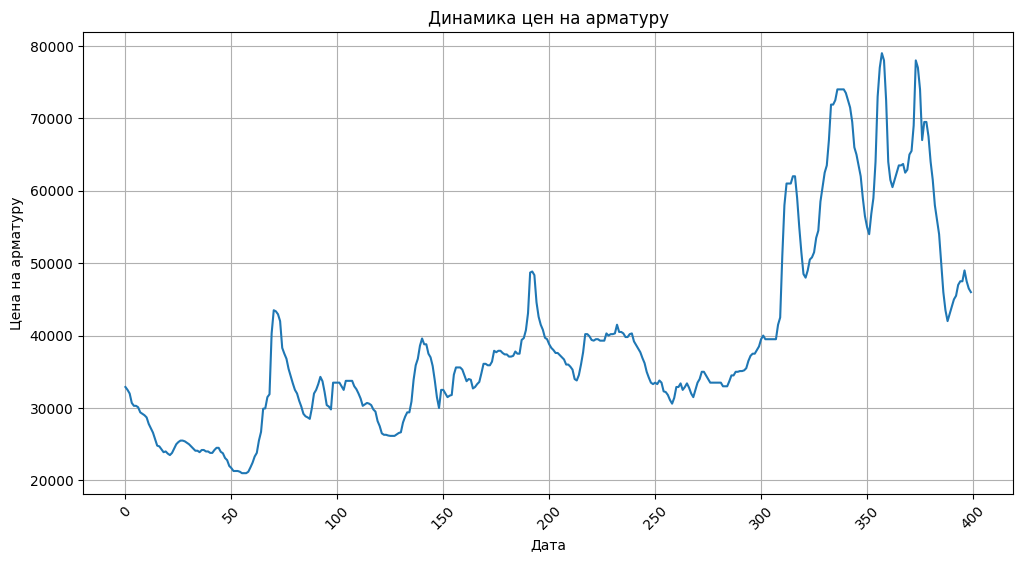

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

**Вопросы к графику:**

 1.Есть ли тренд?

 2.Есть ли сезонность?

 3.Насколько сильный шум?



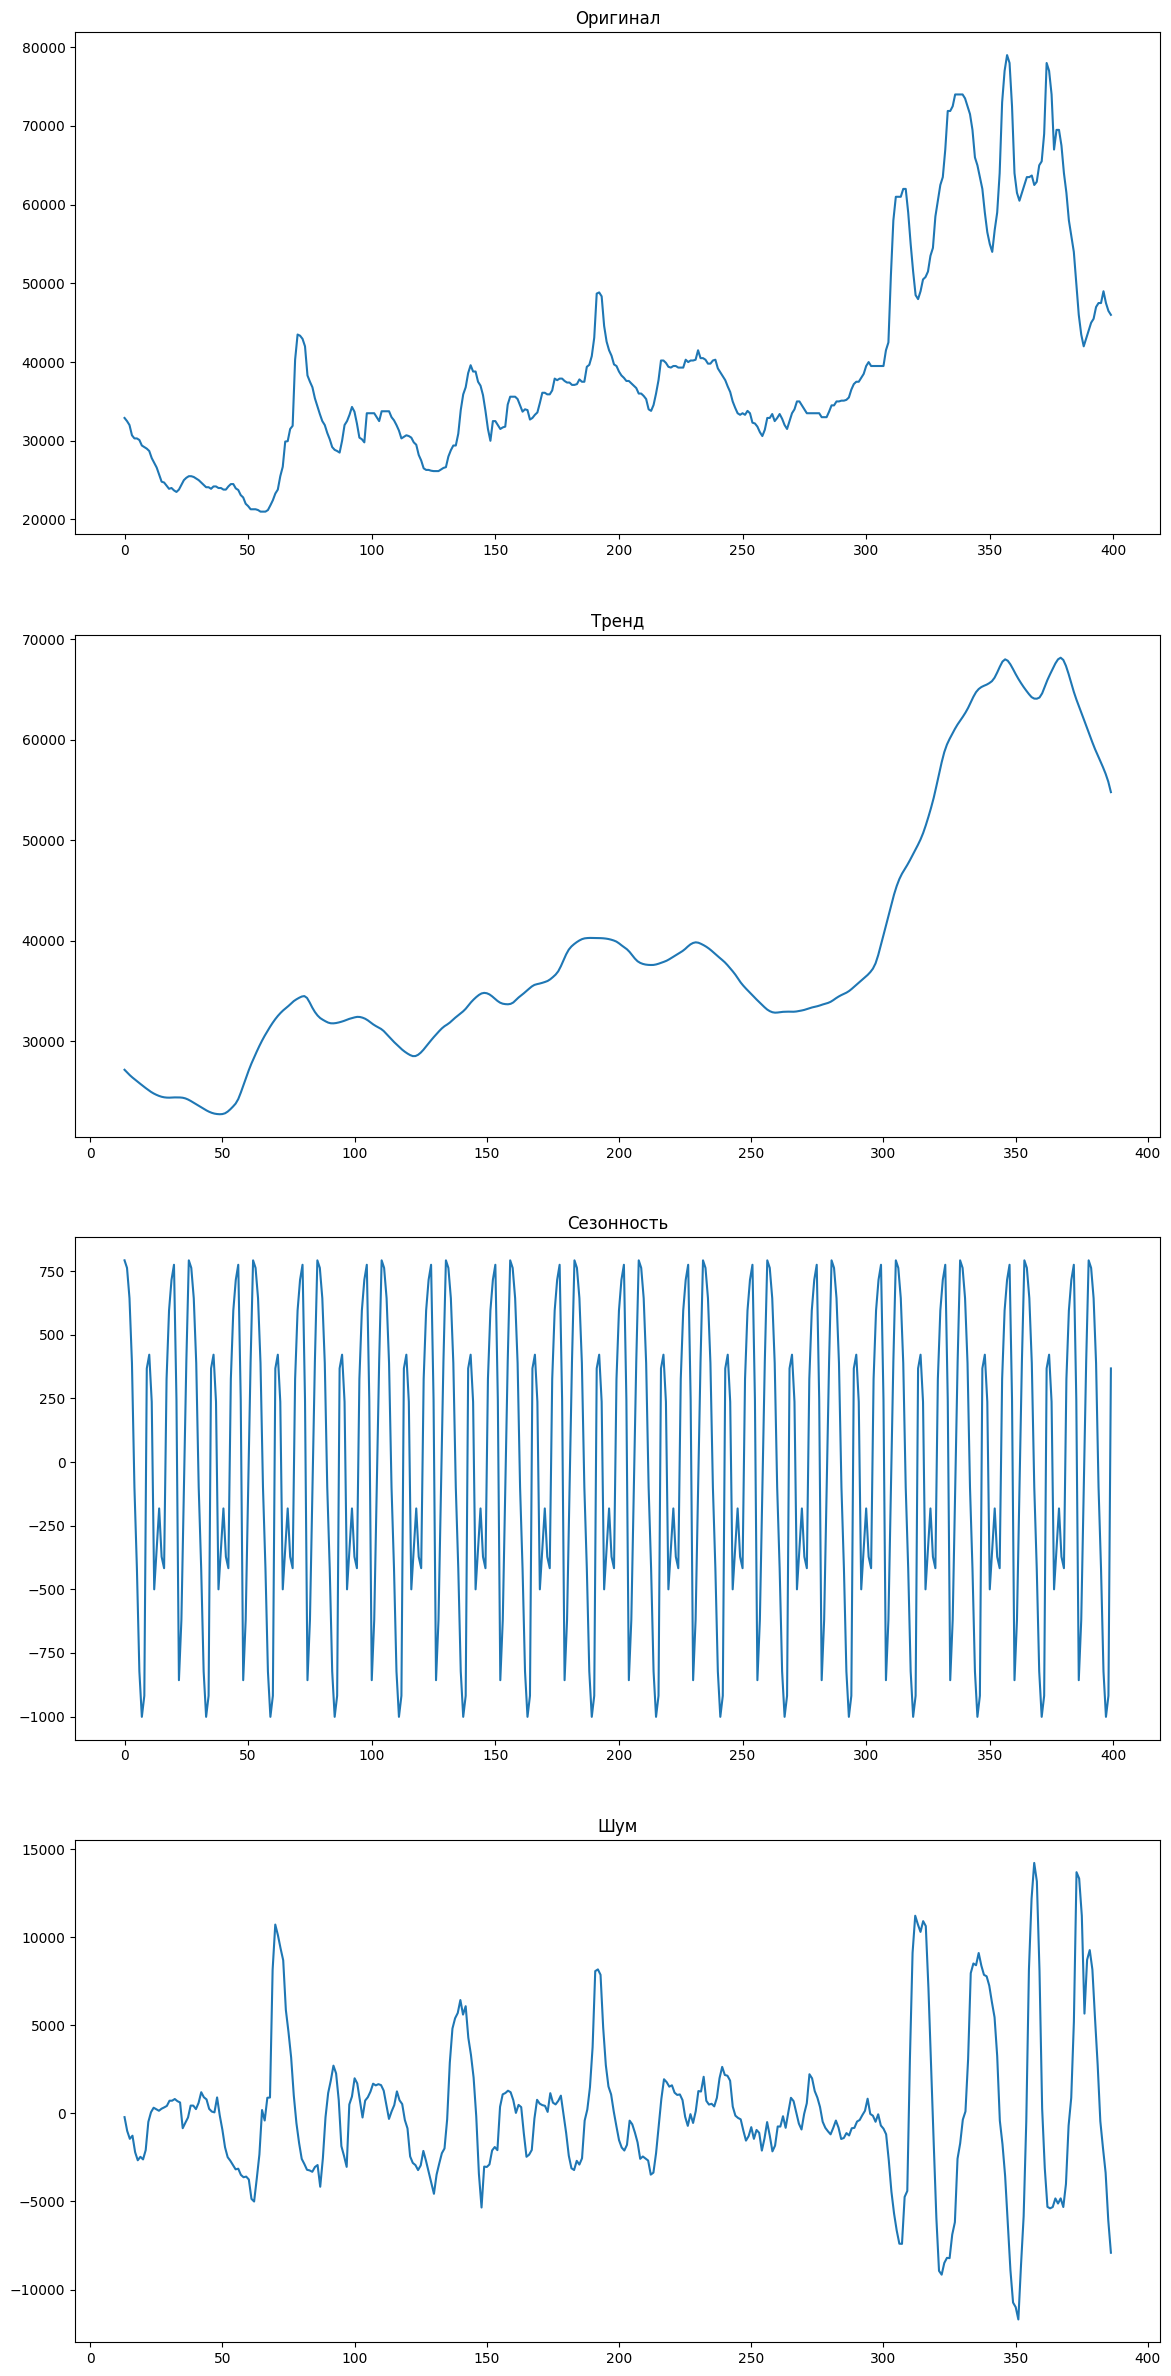

In [10]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Декомпозиция временного ряда


🔹 Оригинальный ряд  


Исходные данные, содержащие тренд, сезонность и шум.


 📈 Тренд

   
Общий восходящий тренд, отражающий долгосрочный рост.


🔄 Сезонность


Выраженные периодические колебания, сохраняющиеся на протяжении всего ряда.


 🔀 Шум  

Умеренный, но увеличивается ближе к концу ряда, что может указывать на аномалии или возрастание волатильности.


### Работа с автокорреляцией

In [11]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

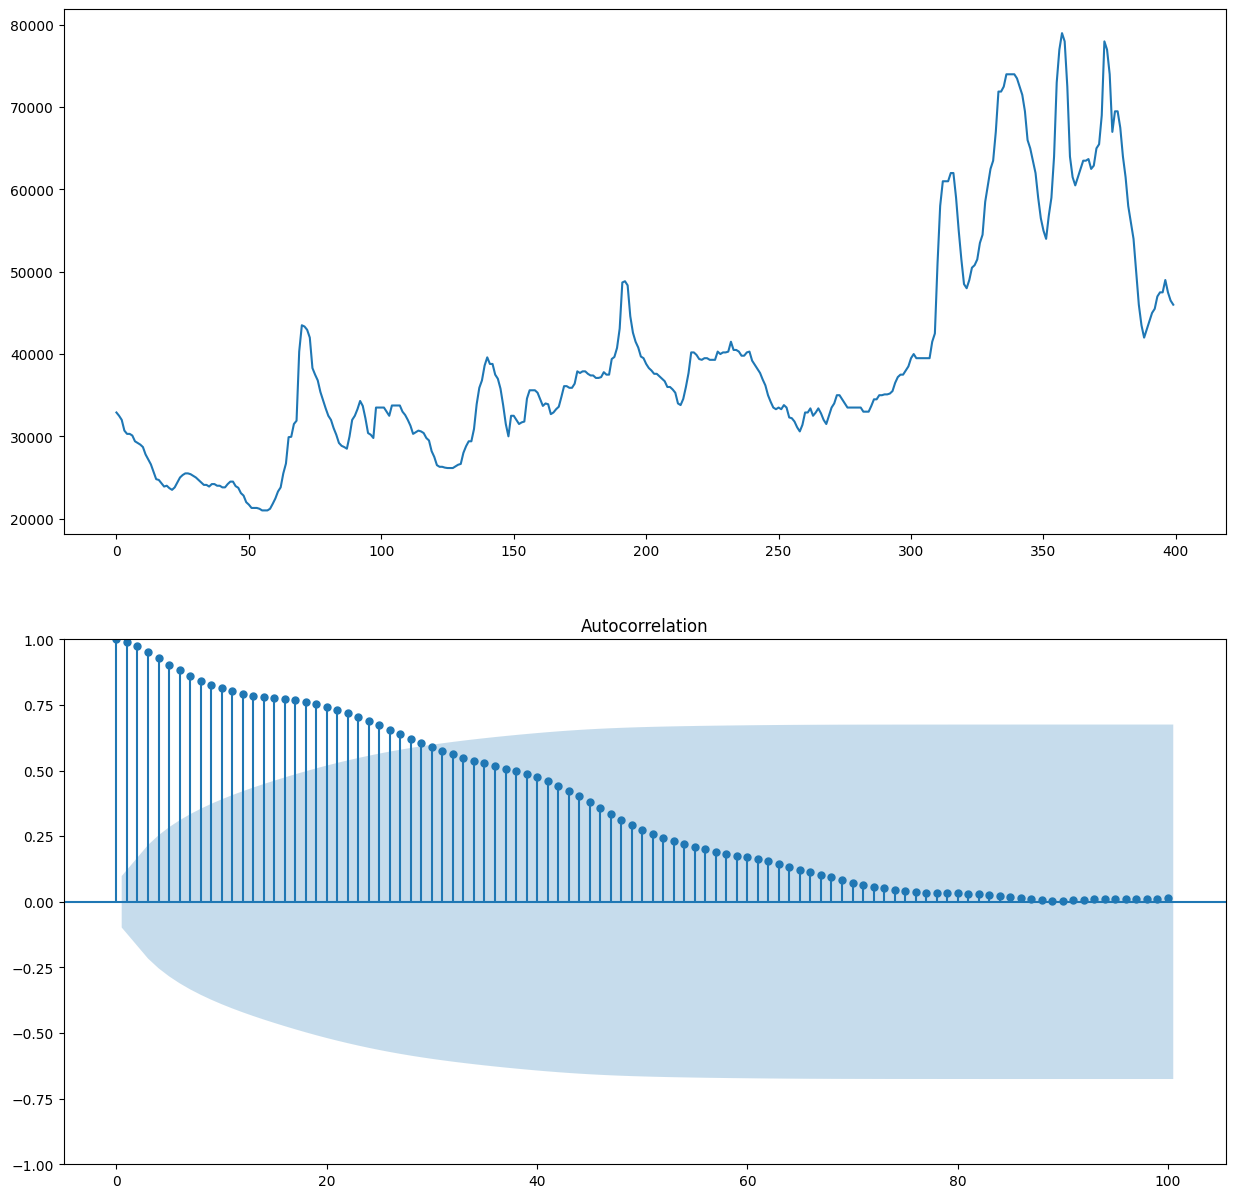

In [12]:
# Визуализация автокорреляции
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

Высокая корреляция на малых лагах указывает на сильную зависимость текущих значений от предыдущих.

Корреляция постепенно уменьшается с увеличением лага, что характерно для многих временных рядов.


Светло-синяя область – это доверительный интервал: значения внутри него можно считать статистически незначимыми.

In [13]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


Text(0.5, 1.0, 'Распределение цен на арматуру')

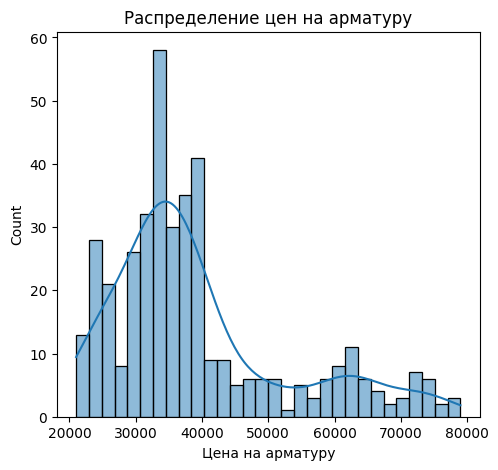

In [14]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")


На графики видем что большинство значений  примерно сосредоточено между 30тыс и 40тыс

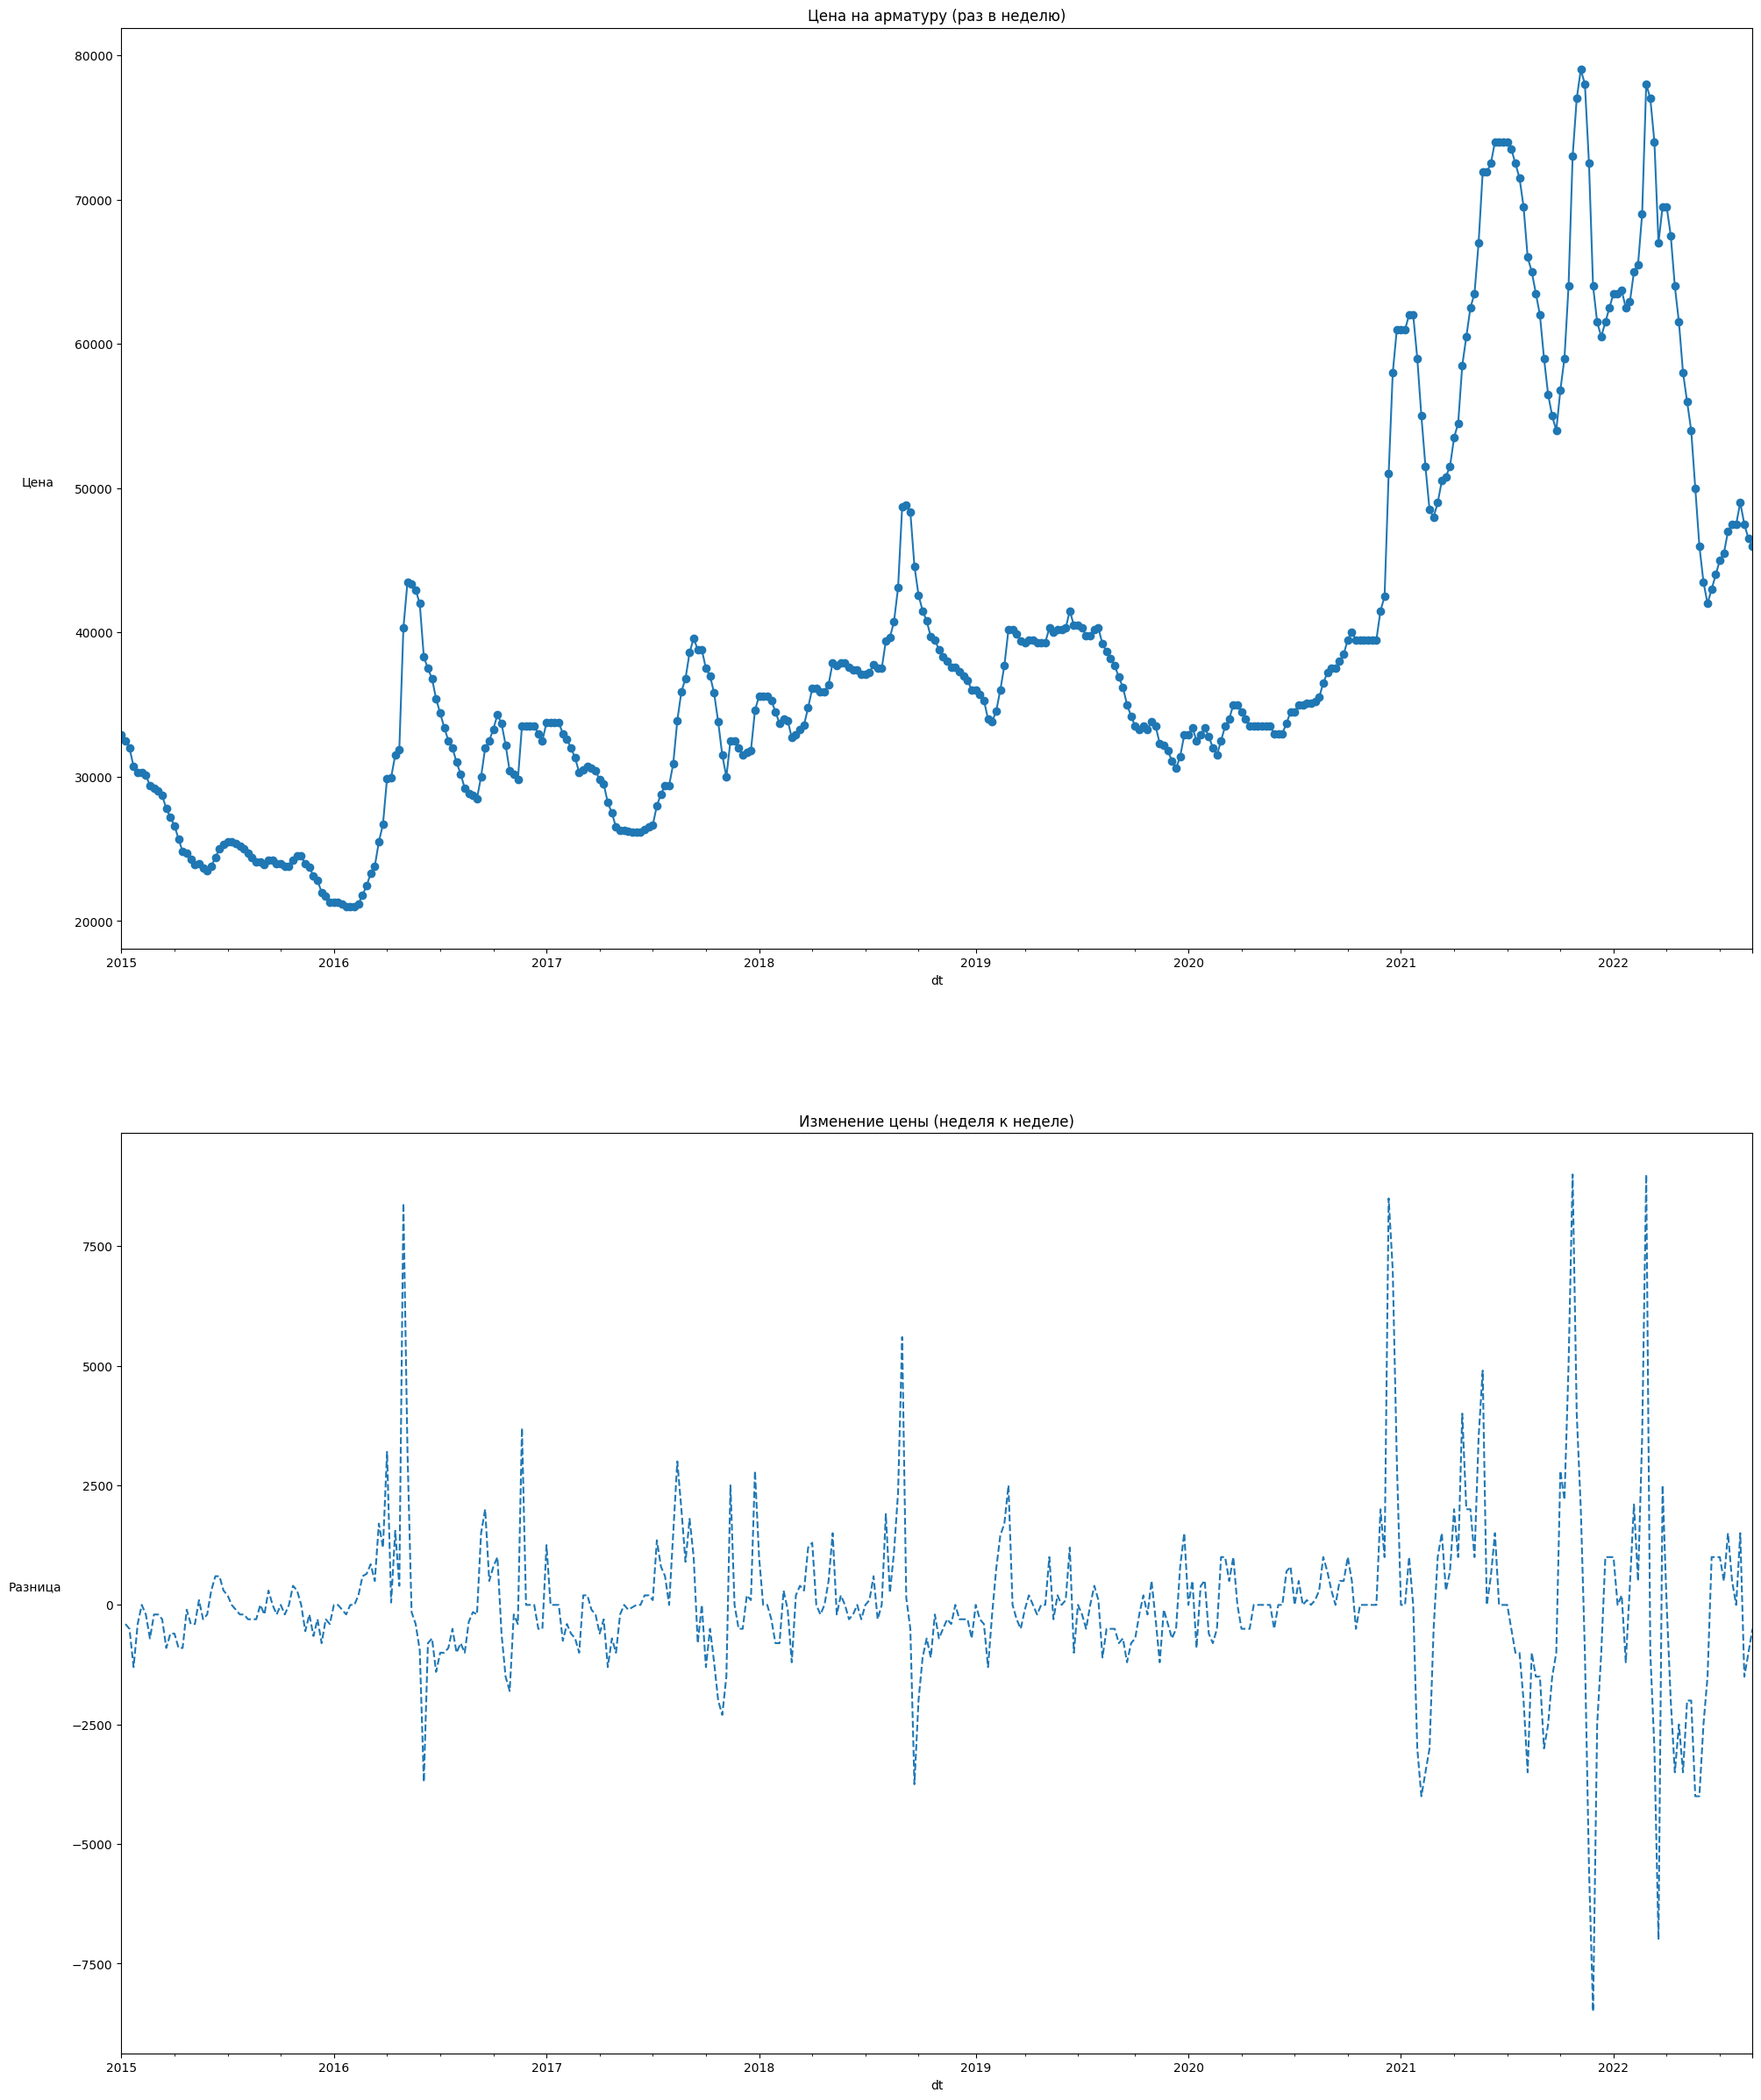

In [15]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()


1. Верхний график – временной ряд цен на аренду.

Видно наличие тренда: долгосрочный рост цен с колебаниями.

Наблюдаются всплески и падения, возможно, сезонные или вызванные внешними факторами.

В последние годы цены достигли пиковых значений, а затем начали снижаться.
___


2. Нижний график – изменения цен (разность цен между соседними точками).

Колебания вокруг нуля указывают на стационарность изменений.

Присутствуют резкие всплески, что говорит о периодах высокой волатильности.

Возможно, есть влияние новостей, кризисов или других внешних событий.



In [16]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   400 non-null    datetime64[ns]
 1   Цена на арматуру     400 non-null    int64         
 2   Цена_разница_неделя  399 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.5 KB


In [17]:
df_ts.replace(np.nan, 0, inplace=True)

In [18]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [19]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Critical Values: {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}
Ряд стационарен (p-value < 0.05)


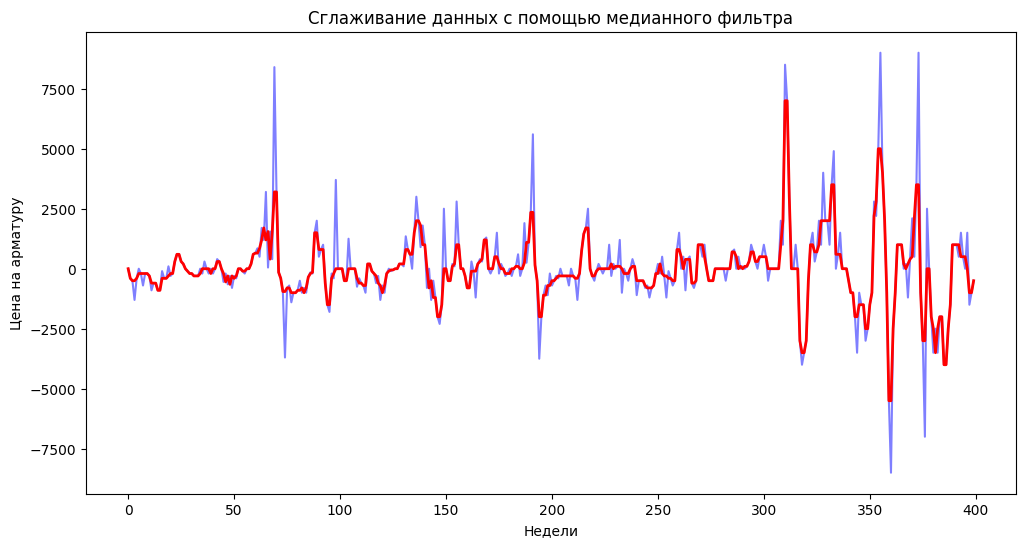

In [20]:
from scipy.signal import medfilt

# Применение медианного фильтра
df_ts["Цена_разница_неделя (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=3)

# Построение графика
plt.figure(figsize=(12, 6))

# Исходные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя"], label="Исходные данные", color='blue', alpha=0.5)

# Сглаженные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя (сглаженная)"], label="Сглаженные данные", color='red', linewidth=2)

# Настройка графика
plt.title("Сглаживание данных с помощью медианного фильтра")
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.show()

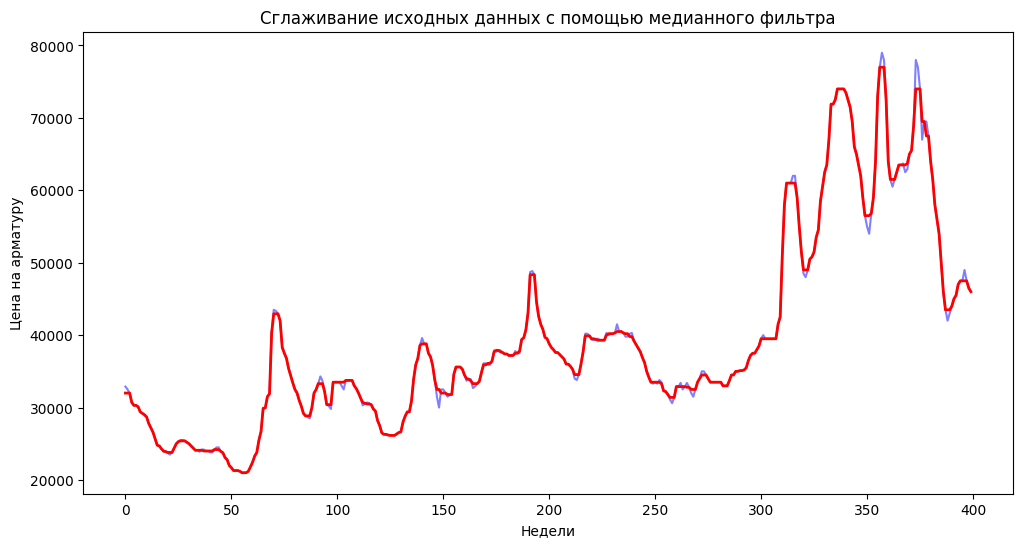

In [21]:
from scipy.signal import medfilt

# Применение медианного фильтра
df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена на арматуру"], kernel_size=5)

# Построение графика
plt.figure(figsize=(12, 6))

# Исходные данные
plt.plot(df_ts.index, df_ts["Цена на арматуру"], label="Исходные данные", color='blue', alpha=0.5)

# Сглаженные данные
plt.plot(df_ts.index, df_ts["Цена на арматуру (сглаженная)"], label="Сглаженные данные", color='red', linewidth=2)

# Настройка графика
plt.title("Сглаживание исходных данных с помощью медианного фильтра")
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.show()

In [22]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])
adf_test(df_ts['Цена_разница_неделя (сглаженная)'])

ADF Statistic: -1.8577310312385495
p-value: 0.35219938092925374
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)
ADF Statistic: -8.108679715553967
p-value: 1.2427490594539653e-12
Critical Values: {'1%': -3.447099431978147, '5%': -2.8689225261604263, '10%': -2.57070269105012}
Ряд стационарен (p-value < 0.05)


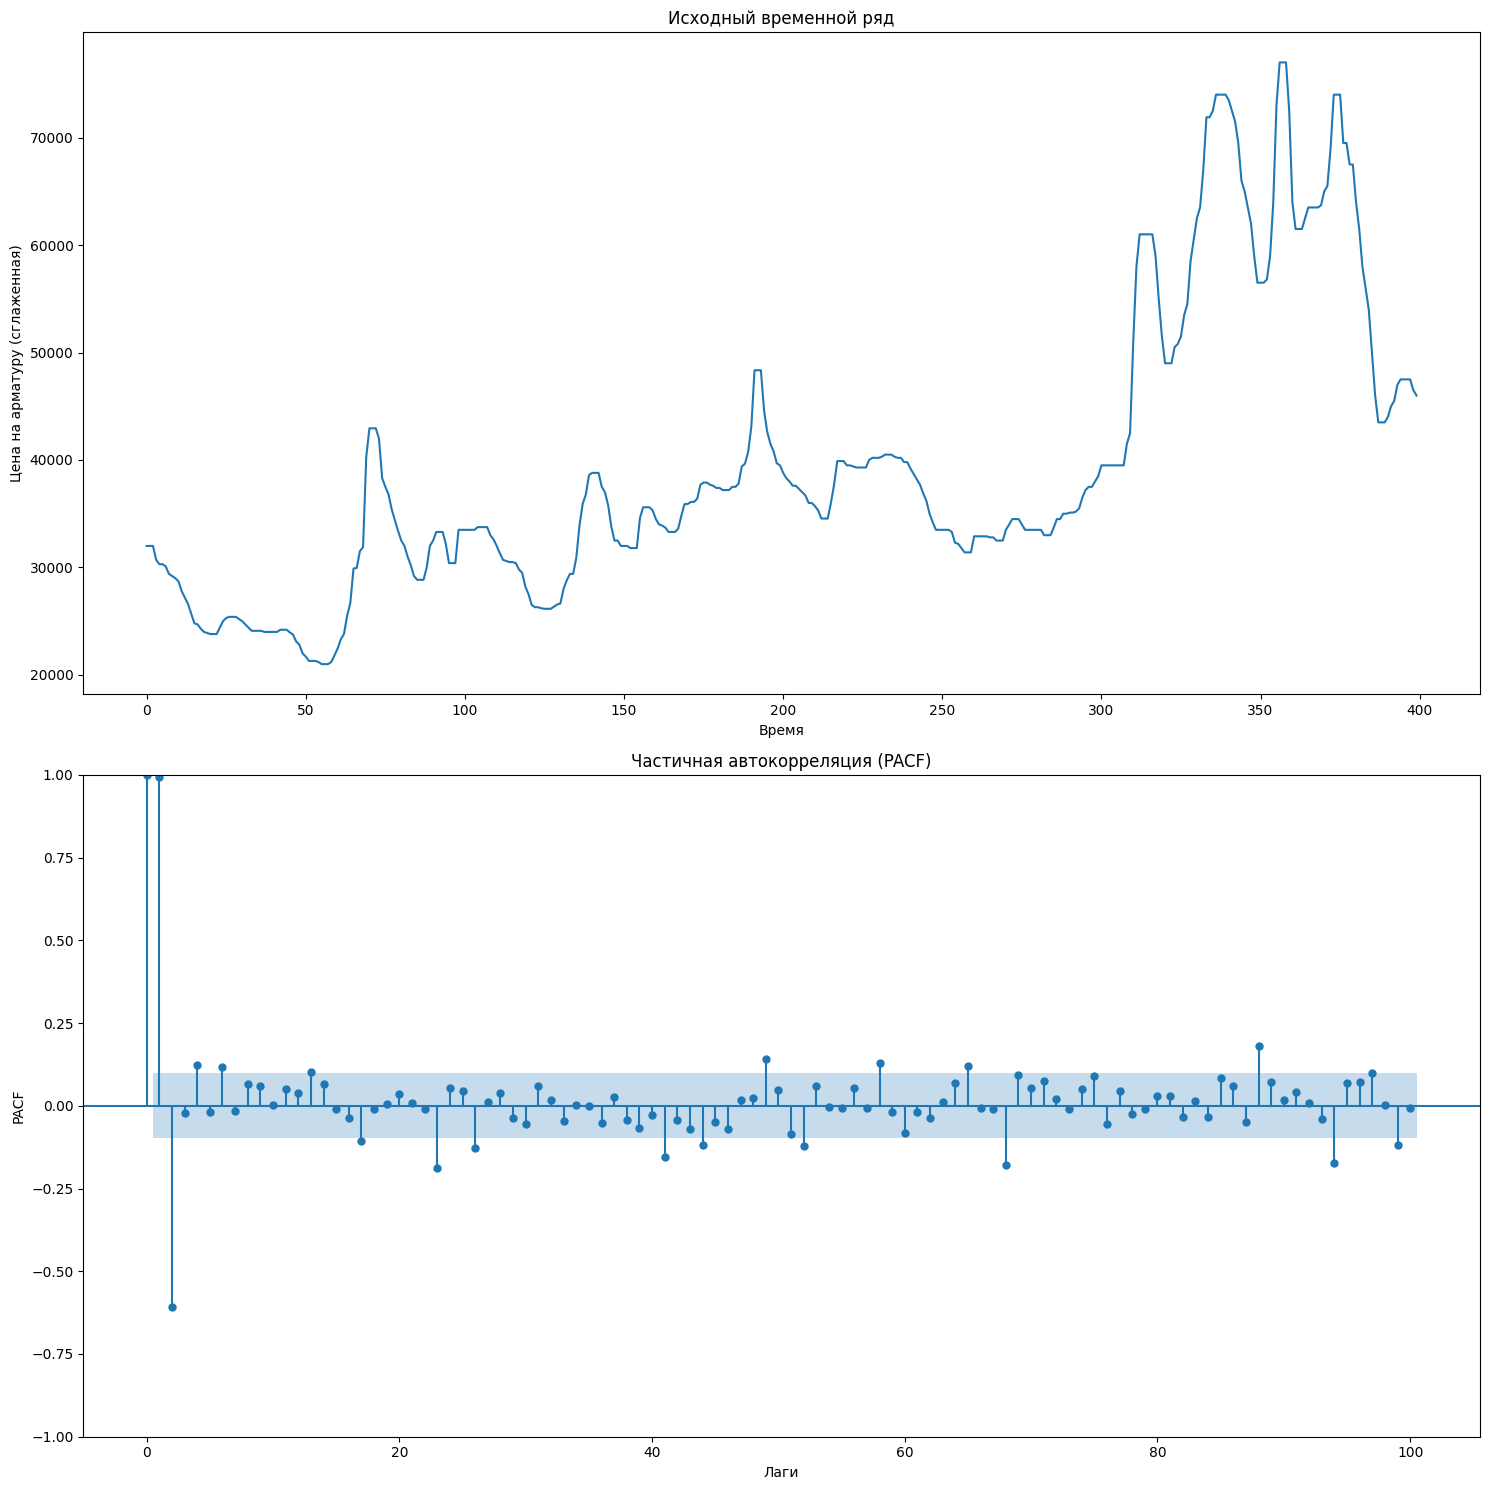

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру (сглаженная)'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру (сглаженная)')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру (сглаженная)'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

1. Верхний график (исходный временной ряд):

Хотя он выглядит волатильным, после проверки на стационарность можно сказать, что данные не содержат явного тренда.

Это значит, что применённые преобразования (медианное сглаживание и дифференцирование) сделали ряд пригодным для моделирования.

Колебания могут указывать на сезонность или авторегрессию.

___

2. Нижний график (PACF):

Высокое значение на первом лаге говорит о сильной краткосрочной зависимости в данных.

Дальнейшие значения колеблются вокруг 0, но есть несколько значимых пиков. Это может указывать на авторегрессионный процесс (AR), возможно, порядка 1 или 2.

Учитывая стационарность, можно попробовать модель AR(p), где p — это порядок, определяемый по PACF (например, если есть значимые пики на 1 и 2 лагах, можно взять AR(2)).


# Модели

### Линейная регрессия

Средняя абсолютная ошибка (MAE): 1725.21
Корень среднеквадратичной ошибки (RMSE): 2206.64
Симметричная MAPE (SMAPE): 165.57%
Коэффициент детерминации (R^2): -0.03


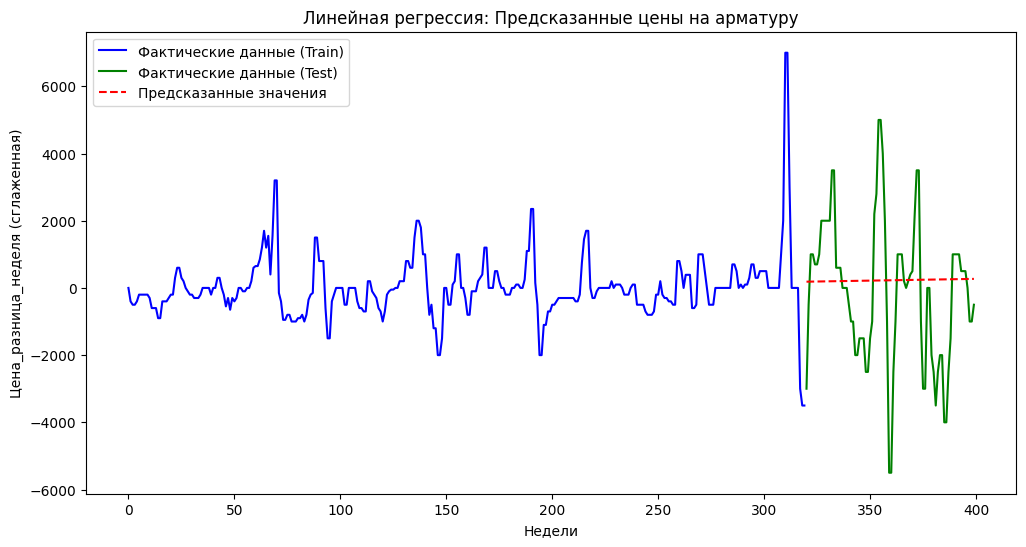

In [24]:
# 2. Предобработка данных
df_ts["weeks"] = (df_ts["dt"] - df_ts["dt"].min()).dt.days // 7  # Преобразуем дату в количество недель

# 3. Определение признаков (X) и целевой переменной (y)
X = df_ts[["weeks"]]  # Количество недель с первой даты
y = df_ts["Цена_разница_неделя (сглаженная)"]  # Цены на арматуру

# Разделение данных на обучающую и тестовую выборки
split_index = int(len(X) * 0.8)
X_train_lr, X_test_lr = X[:split_index], X[split_index:]
y_train_lr, y_test_lr = y[:split_index], y[split_index:]

# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# 6. Получение предсказаний
y_pred_lr = model.predict(X_test_lr)

# 7. Оценка качества модели

# Средняя абсолютная ошибка (MAE)
mae_lr = mean_absolute_error(y_test_lr, y_pred_lr)

# Корень среднеквадратичной ошибки (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))

# Симметричная MAPE (SMAPE)
smape_lr = np.mean(2 * np.abs(y_test_lr - y_pred_lr) / (np.abs(y_test_lr) + np.abs(y_pred_lr))) * 100

# Коэффициент детерминации (R^2)
r2_lr = r2_score(y_test_lr, y_pred_lr)

# Средняя точность направления (MDA) с выравниванием индексов
y_test = y_test_lr
y_pred = pd.Series(y_pred_lr, index=y_test_lr.index)

# Убираем несовпадающие индексы
common_index = y_test.index.intersection(y_pred.index)

mda_lr = np.mean(np.sign(y_test.loc[common_index]) == np.sign(y_pred.loc[common_index]))

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae_lr:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_lr:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape_lr:.2f}%")
print(f"Коэффициент детерминации (R^2): {r2_lr:.2f}")


# 9. Визуализация результатов
plt.figure(figsize=(12, 6))

# Линия фактических данных (Train)
plt.plot(X_train_lr, y_train_lr, color="blue", label="Фактические данные (Train)")

# Линия фактических данных (Test)
plt.plot(X_test_lr, y_test_lr, color="green", label="Фактические данные (Test)")

# Линия предсказаний (Test)
plt.plot(X_test_lr, y_pred_lr, color="red", linestyle="dashed", label="Предсказанные значения")

plt.xlabel("Недели")
plt.ylabel("Цена_разница_неделя (сглаженная)")
plt.title("Линейная регрессия: Предсказанные цены на арматуру")
plt.legend()
plt.show()

### Arima

In [25]:
# Разделим данные на тренировочные и тестовые выборки (80%/20%)
train_size_a = int(len(df_ts) * 0.8)
train_a, test_a = df_ts['Цена_разница_неделя (сглаженная)'][:train_size_a], df_ts['Цена_разница_неделя (сглаженная)'][train_size_a:]

# Применим auto_arima для подбора модели ARIMA
model = auto_arima(train_a, seasonal=False, stepwise=True, trace=True)

# Выводим информацию о лучшей модели
print(f"Лучшие параметры ARIMA: {model.order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4960.120, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5314.108, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5012.833, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5087.915, Time=1.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4962.189, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4965.332, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4959.610, Time=3.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4967.031, Time=0.56 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4961.644, Time=1.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=8.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4960.097, Time=1.59 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4960.760, Time=2.37 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=3.66 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4961.691, Time=4.59 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]       

In [26]:
# Выбираем столбец с данными временного ряда
time_series_a = df_ts['Цена_разница_неделя (сглаженная)']
model = ARIMA(time_series_a, order= model.order )
fitted_model = model.fit()


MAE: 769.0646
RMSE: 1098.8027
SMAPE: 75.17%
R^2: 0.7440


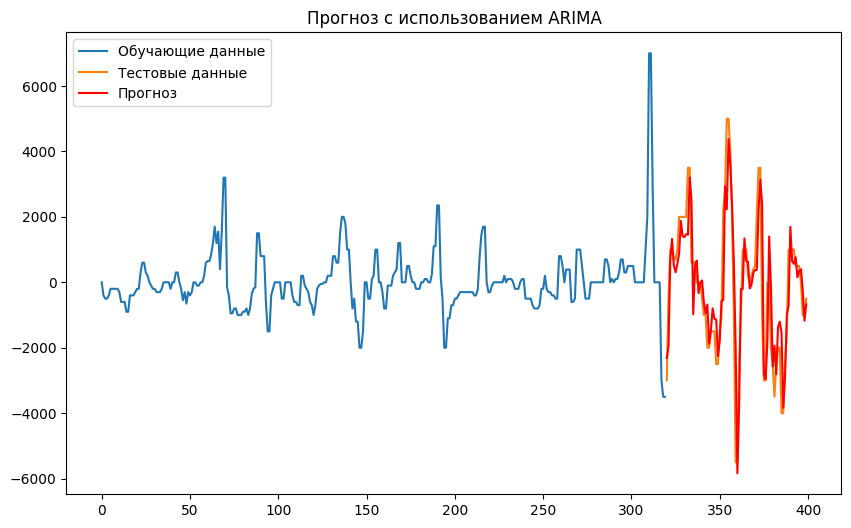

In [27]:
# Прогнозируем на тестовых данных
forecast = fitted_model.predict(start=len(train_a), end=len(train_a) + len(test_a) - 1)

from sklearn.metrics import r2_score  # Импортируем r2_score

# Средняя абсолютная ошибка (MAE)
mae_a = mean_absolute_error(test_a, forecast)
print(f"MAE: {mae_a:.4f}")

# Корень среднеквадратичной ошибки (RMSE)
rmse_a = np.sqrt(mean_squared_error(test_a, forecast))
print(f"RMSE: {rmse_a:.4f}")

# Симметричная MAPE (SMAPE)
smape_a = np.mean(2 * np.abs(forecast - test_a) / (np.abs(test_a) + np.abs(forecast))) * 100
print(f"SMAPE: {smape_a:.2f}%")

# Коэффициент детерминации (R^2)
r2_a = r2_score(test_a, forecast)
print(f"R^2: {r2_a:.4f}")

# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train_a, label='Обучающие данные')
plt.plot(test_a, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()

### SARIMA

                                      SARIMAX Results                                       
Dep. Variable:     Цена_разница_неделя (сглаженная)   No. Observations:                  320
Model:             SARIMAX(3, 0, 2)x(4, 2, [1], 20)   Log Likelihood               -2261.711
Date:                              Sat, 22 Mar 2025   AIC                           4545.421
Time:                                      21:10:29   BIC                           4585.404
Sample:                                           0   HQIC                          4561.459
                                              - 320                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0489      0.155     -0.314      0.753      -0.354       0.256
ar.L2          0.70

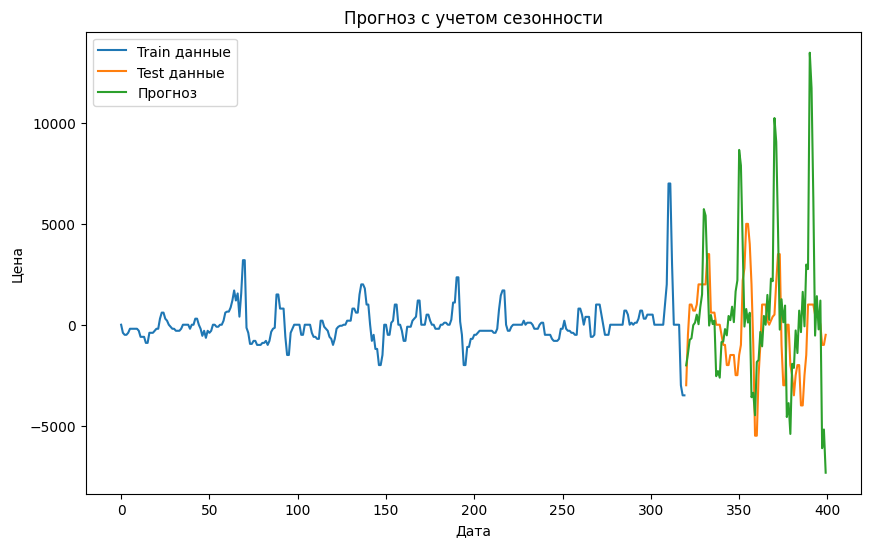

In [28]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Загрузка данных
data = df_ts['Цена_разница_неделя (сглаженная)']

# Разделение данных на обучающую и тестовую выборки
train_size_sa = int(len(data) * 0.8)
train_sa, test_sa = data[:train_size_sa], data[train_size_sa:]

# Создание и обучение модели SARIMA с заданными параметрами
model = SARIMAX(
    train_sa,
    order=(3, 0, 2),              # Несезонные параметры (p, d, q)
    seasonal_order=(3, 2, 1, 20)  # Сезонные параметры (P, D, Q, m)
)
results = model.fit()

# Вывод результатов обучения
print(results.summary())

# Прогнозирование на test данные
forecast_sa = results.get_forecast(steps=len(test_sa)).predicted_mean

# Вычисление метрик качества модели
# 1. Средняя абсолютная ошибка (MAE)
mae_sa = mean_absolute_error(test_sa, forecast_sa)

# 2. Корень среднеквадратичной ошибки (RMSE)
rmse_sa = np.sqrt(mean_squared_error(test_sa, forecast_sa))

# 3. Симметричная MAPE (SMAPE)
smape_sa = np.mean(2 * np.abs(test_sa - forecast_sa) / (np.abs(test_sa) + np.abs(forecast_sa))) * 100

# 4. Коэффициент детерминации (R^2)
r2_sa = r2_score(test_sa, forecast_sa)



# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae_sa:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_sa:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape_sa:.2f}%")
print(f"Коэффициент детерминации (R^2): {r2_sa:.4f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(train_sa.index, train_sa, label='Train данные')  # Обучающие данные
plt.plot(test_sa.index, test_sa, label='Test данные')    # Фактические значения test данных
plt.plot(test_sa.index, forecast_sa, label='Прогноз')    # Прогноз модели
plt.title('Прогноз с учетом сезонности')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()



### LSTM

In [29]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# 3. Нормализация данных

scaler_price = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler_price.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

scaler_weeks = MinMaxScaler(feature_range=(0, 1))
df_ts["weeks"] = scaler_weeks.fit_transform(df_ts[["weeks"]])

# Масштабируем новые признаки
scaler_diff = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена_разница_неделя (сглаженная)"] = scaler_diff.fit_transform(df_ts[["Цена_разница_неделя (сглаженная)"]])

# Разделение на train/test
train_size_lstm = int(len(df_ts) * 0.8)
train_lstm, test_lstm = df_ts.iloc[:train_size_lstm], df_ts.iloc[train_size_lstm:]

# Функция для создания окон временного ряда с несколькими признаками
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Берем все признаки
        y.append(data.iloc[i+seq_length]["Цена на арматуру (сглаженная)"])  # Целевая переменная
    return np.array(X), np.array(y)

seq_length = 20  # Длина окна

# Формируем обучающие данные с 3 признаками
X_train, y_train = create_sequences(train_lstm[["Цена на арматуру (сглаженная)", "weeks", "Цена_разница_неделя (сглаженная)"]], seq_length)
X_test, y_test = create_sequences(test_lstm[["Цена на арматуру (сглаженная)", "weeks", "Цена_разница_неделя (сглаженная)"]], seq_length)

# Изменяем форму данных для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))  # 3 признака
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

In [30]:
df_ts.head()

,dt,Цена на арматуру,Цена_разница_неделя,Цена_разница_неделя (сглаженная),Цена на арматуру (сглаженная),weeks
0,2015-01-05,32900,0.0,0.440,0.196429,0.000000
1,2015-01-12,32500,-400.0,0.408,0.196429,0.002506
2,2015-01-19,32000,-500.0,0.400,0.196429,0.005013
3,2015-01-26,30700,-1300.0,0.400,0.173214,0.007519
4,2015-02-02,30300,-400.0,0.408,0.166071,0.010025


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Bidirectional, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2

seq_length = 20
batch_size = 4

# Оптимизированная модель
model = Sequential([
    BatchNormalization(input_shape=(seq_length, 3)),

    # Два Conv1D слоя для выделения локальных признаков
    Conv1D(64, kernel_size=3, activation="relu", padding="same"),
    Conv1D(64, kernel_size=3, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    # Основной LSTM блок
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.005))),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.005))),
    Dropout(0.3),

    # Выходные Dense слои
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(1)
])

# Компиляция с обновленным оптимизатором
optimizer = Adam(learning_rate=0.005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0))

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Обучение
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150,
                    batch_size=batch_size, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.7727 - val_loss: 0.0620 - learning_rate: 0.0050
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0070 - val_loss: 0.0819 - learning_rate: 0.0050
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0071 - val_loss: 0.0739 - learning_rate: 0.0050
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0080 - val_loss: 0.0681 - learning_rate: 0.0050
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032 - val_loss: 0.0207 - learning_rate: 1.0000e-03
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0352 - learning_rate: 1.0000e-03
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0037 - val_loss: 0.0103 - learning_rate: 

In [32]:
# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler_price.inverse_transform(y_test.reshape(-1, 1))  # Исправлен scaler
y_pred_inv = scaler_price.inverse_transform(y_pred.reshape(-1, 1))

# Преобразуем y_test в Series с индексами
y_test_series = pd.Series(y_test_inv.flatten())

# 1. Средняя абсолютная ошибка (MAE)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

# 2. Корень среднеквадратичной ошибки (RMSE)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# 3. Симметричная MAPE (SMAPE)
smape_lstm = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv))) * 100

# 4. Коэффициент детерминации (R^2)
r2_lstm = r2_score(y_test_inv, y_pred_inv)



# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae_lstm:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_lstm:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape_lstm:.2f}%")
print(f"Коэффициент детерминации (R^2): {r2_lstm:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Средняя абсолютная ошибка (MAE): 3806.95
Корень среднеквадратичной ошибки (RMSE): 4521.20
Симметричная MAPE (SMAPE): 6.74%
Коэффициент детерминации (R^2): 0.7967


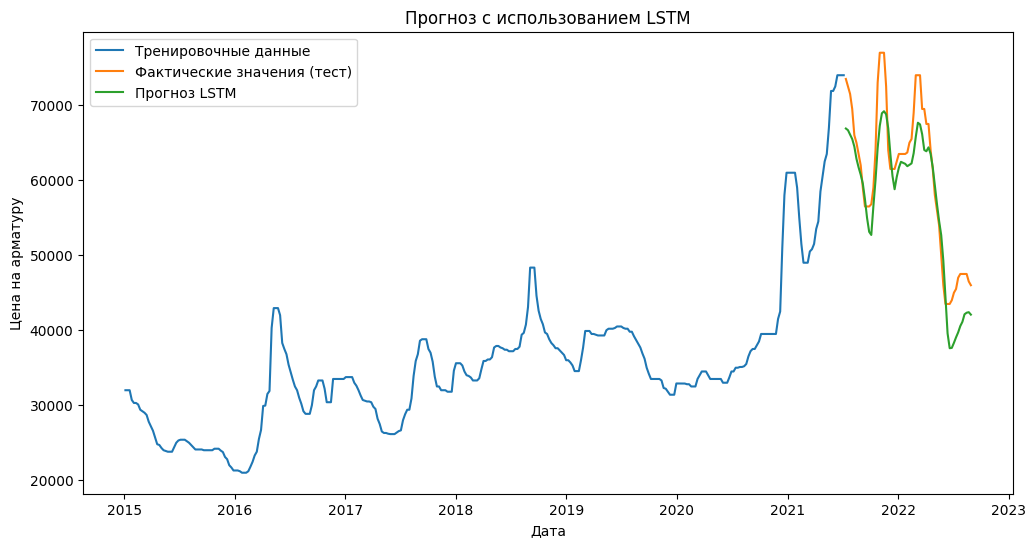

In [33]:
# Подготовка данных для визуализации
train_dates = df_ts['dt'][:train_size_lstm + seq_length]
test_dates = df_ts['dt'].iloc[train_size_lstm + seq_length: train_size_lstm + seq_length + len(y_test)]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_ts['dt'][:train_size_lstm + seq_length],
         scaler_price.inverse_transform(df_ts[["Цена на арматуру (сглаженная)"]])[:train_size_lstm + seq_length],
         label="Тренировочные данные")
plt.plot(test_dates, y_test_inv, label="Фактические значения (тест)")
plt.plot(test_dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием LSTM")
plt.legend()
plt.show()

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0159 - val_loss: 0.0197
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.1394e-04 - val_loss: 0.0032
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.1907e-04 - val_loss: 0.0039
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 8.7994e-04 - val_loss: 0.0013
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9.3702e-04 - val_loss: 0.0019
Epoch 8/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 4.5799e-04 - val_loss: 0.0014
Epoch 9/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.8497e-04 - val_loss: 0.0040
Epoch 10/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.9106e-04 - val_loss: 0.0016
Epoch 11/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.4978e-04 - val_loss: 0.0024
Epoch 12/300
38/38 

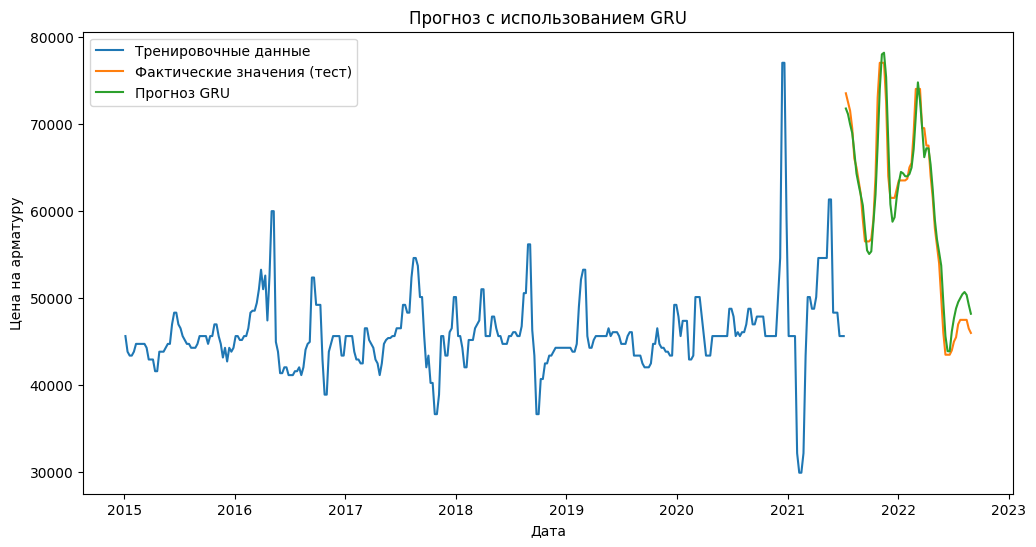

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Новая модель GRU с улучшениями
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True, input_shape=(seq_length, 3))),
    Dropout(0.2),
    GRU(64),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Добавлен EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение
history = model.fit(X_train, y_train, epochs=300, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Предсказания
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler_price.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_price.inverse_transform(y_pred.reshape(-1, 1))

# Вычисление метрик
mae_g = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_g = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
smape_g = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv))) * 100
r2_g = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae_g:.2f}")
print(f"RMSE: {rmse_g:.2f}")
print(f"SMAPE: {smape_g:.2f}%")
print(f"R^2: {r2_g:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df_ts['dt'][:train_size_lstm + seq_length],
         scaler_price.inverse_transform(df_ts[["Цена_разница_неделя (сглаженная)"]])[:train_size_lstm + seq_length],
         label="Тренировочные данные")
plt.plot(df_ts['dt'].iloc[train_size_lstm + seq_length: train_size_lstm + seq_length + len(y_test)],
         y_test_inv, label="Фактические значения (тест)")
plt.plot(df_ts['dt'].iloc[train_size_lstm + seq_length: train_size_lstm + seq_length + len(y_test)],
         y_pred_inv, label="Прогноз GRU")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием GRU")
plt.legend()
plt.show()

## Лучшая модель

## Лучшая модель


Лучшая модель (по комплексной оценке): GNU
Linear Regression: 0.2528
ARIMA: 0.7285
SARIMA: -0.5287
LSTM: 0.4410
GNU: 0.7763


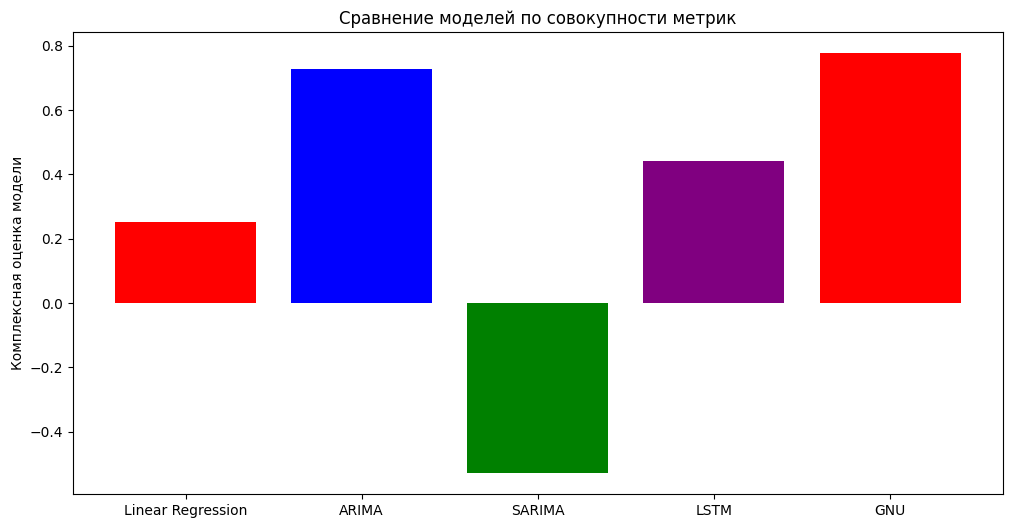

In [35]:
# Словарь для хранения метрик всех моделей
model_metrics = {
    "Linear Regression": {
        "MAE": mae_lr,
        "RMSE": rmse_lr,
        "R^2": r2_lr,
        "SMAPE": smape_lr,

    },
    "ARIMA": {
        "MAE": mae_a,
        "RMSE": rmse_a,
        "R^2": r2_a,
        "SMAPE": smape_a,

    },
    "SARIMA": {
        "MAE": mae_sa,
        "RMSE": rmse_sa,
        "R^2": r2_sa,
        "SMAPE": smape_sa,

    },
    "LSTM": {
        "MAE": mae_lstm,
        "RMSE": rmse_lstm,
        "R^2": r2_lstm,
        "SMAPE": smape_lstm,

    },
    "GNU": {
        "MAE": mae_g,
        "RMSE": rmse_g,
        "R^2": r2_g,
        "SMAPE": smape_g,
    }
}

# Определяем максимальные значения для нормализации
max_mae = max(m["MAE"] for m in model_metrics.values())
max_rmse = max(m["RMSE"] for m in model_metrics.values())
max_r2 = max(m["R^2"] for m in model_metrics.values())
max_smape = max(m["SMAPE"] for m in model_metrics.values())

# Веса метрик (можно настроить по приоритету)
alpha, beta, gamma, delta = 0.2, 0.3, 0.3, 0.2,   # MAE, RMSE, R², SMAPE, MDA

# Вычисление общего рейтинга для каждой модели
model_scores = {}
for model, metrics in model_metrics.items():
    score = (
        alpha * (1 - metrics["MAE"] / max_mae) +     # Чем меньше MAE, тем лучше
        beta * (1 - metrics["RMSE"] / max_rmse) +    # Чем меньше RMSE, тем лучше
        gamma * (metrics["R^2"] / max_r2) +          # Чем выше R², тем лучше
        delta * (1 - metrics["SMAPE"] / max_smape) #+  # Чем меньше SMAPE, тем лучше

    )
    model_scores[model] = score

# Определяем лучшую модель
best_model = max(model_scores, key=model_scores.get)

# Вывод результатов
print("\nЛучшая модель (по комплексной оценке):", best_model)
for model, score in model_scores.items():
    print(f"{model}: {score:.4f}")

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))
plt.bar(model_scores.keys(), model_scores.values(), color=["red", "blue", "green", "purple"])
plt.ylabel("Комплексная оценка модели")
plt.title("Сравнение моделей по совокупности метрик")
plt.show()